### U-net architecture implemented in pytorch and trained on the Mri-brain-tumor dataset.


1.   The dataset contains 3064 grayscaled mriscans with their corresponding   
     masks.
2.   The model contains ~= 2 million (404 mb) trainable paramater outputing a single channel filter ( the predicted mask )

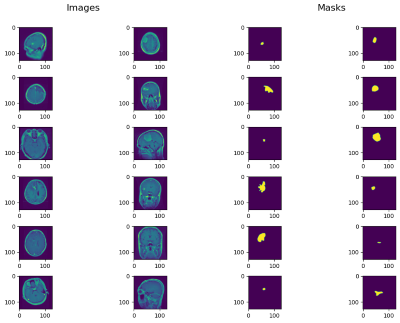  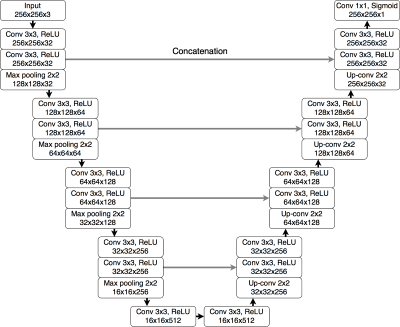


Training configuration:


*   epochs: 300
*   optimizer: Adam using 0.0001 learning rate
*   loss function: dice loss
*   batch size: 16

=================================================#


*   Intial Loss: 0.96
*   Final Loss: 0.078


*   Intial Accuracy: 0.28
*   Final Accuracy: 0.78


=================================================#

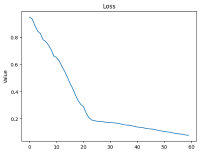 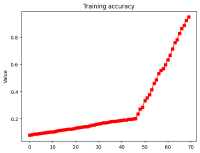 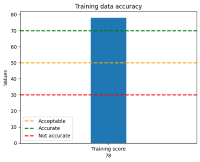






Dataset: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

More info about U-net:  https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/




In [8]:
#================ main pytorch modules =======================#
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
#===============================================================#

#====================== torchvision modules ==========================#
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
#========================================================================#


#====================== visualization modules ==============================#
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
#============================================================================#


#============================ file handling modules ===========================#
import sys
import os
#========================================================================#

import numpy as np

Setting up environment. For faster execution use gpu. Select Runtime->change runtime type->gpu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Model architecture

In [3]:
def Conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride =1 , padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size =3, stride = 1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, init_features):
        super(UNet, self).__init__()
        features = init_features

        #=================Encoder Block===========================#
        self.EncoderBlock = self.initEncoderBlock(in_channels, features)
        #============================================================#


        #====================Botleneck Block=========================#
        self.bottleneck = Conv_block(features * 8, features * 16)
        #==========================================================#

        #==============================Decoder Block============================================#
        self.DecoderBlock = self.initDecoderBlock(in_channels, features)
        #=========================================================================================#


        #================ Final convolution layer=================================#
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
        #==========================================================================#


    def forward(self, x):
        #=================Encoder Block===========================#
        enc1 = self.EncoderBlock._modules['encoder_1'](x)
        enc2 = self.EncoderBlock._modules['encoder_2'](self.EncoderBlock._modules['pool1'](enc1))
        enc3 = self.EncoderBlock._modules['encoder_3'](self.EncoderBlock._modules['pool2'](enc2))
        enc4 = self.EncoderBlock._modules['encoder_4'](self.EncoderBlock._modules['pool3'](enc3))
        #============================================================#

        #====================Botleneck Block=========================#
        bottleneck = self.bottleneck(self.EncoderBlock._modules['pool4'](enc4))
        #==========================================================#

        #==============================Decoder Block============================================#
        dec4 = self.DecoderBlock._modules['up_conv4'](bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.DecoderBlock._modules['decoder_4'](dec4)

        dec3 = self.DecoderBlock._modules['up_conv3'](dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.DecoderBlock._modules['decoder_3'](dec3)

        dec2 = self.DecoderBlock._modules['up_conv2'](dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.DecoderBlock._modules['decoder_2'](dec2)

        dec1 = self.DecoderBlock._modules['up_conv1'](dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.DecoderBlock._modules['decoder_1'](dec1)
        #=========================================================================================#


        #================ Final convolution layer=================================#
        output = self.conv(dec1)
        #================ Final convolution layer=================================#

        return torch.sigmoid(output)

    def initEncoderBlock(self, in_channels, features):
        return nn.Sequential(
        OrderedDict([
            ("encoder_1", Conv_block(in_channels, features)),
            ("pool1", nn.MaxPool2d(kernel_size=2, stride=2)),
            ("encoder_2", Conv_block(features, features * 2)),
            ("pool2", nn.MaxPool2d(kernel_size=2, stride=2)),
            ("encoder_3", Conv_block(features * 2, features * 4)),
            ("pool3", nn.MaxPool2d(kernel_size=2, stride=2)),
            ("encoder_4", Conv_block(features * 4, features * 8)),
            ("pool4", nn.MaxPool2d(kernel_size=2, stride=2)),
        ])
    )
    def initDecoderBlock(self, in_channels, features):
        return nn.Sequential(
        OrderedDict([
                    ("up_conv4",  nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)),
                    ("decoder_4", Conv_block((features * 8) * 2, features * 8)),
                    ("up_conv3", nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)),
                    ("decoder_3",  Conv_block((features * 4) * 2, features * 4)),
                     ("up_conv2", nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)),
                     ("decoder_2",  Conv_block((features * 2) * 2, features * 2)),
                    ("up_conv1",nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)),
                    ("decoder_1",  Conv_block(features * 2, features)),
        ])
    )

Preparing model

In [4]:
from torchsummary import summary

if not os.path.exists('/content/Models/'):
  !git clone https://github.com/ahmedjlidi/Models
weights_path = '/content/Models/unet/brain_mri_unet.pth'
weights = torch.load(weights_path, map_location = device)

model = UNet(in_channels = 1, out_channels= 1, init_features = 16)
model.load_state_dict(weights)

for param in model.parameters():
    param.requires_grad = False
model.eval()

summary(model, (1, 128, 128))

Cloning into 'Models'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 7.93 MiB | 13.85 MiB/s, done.


<ipython-input-4-6635b8466094>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location = device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,608
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,216
      BatchNorm2d-12           [-1, 32, 64, 64]              64
             ReLU-13           [-1, 32, 64, 64]               0
        MaxPool2d-14           [-1, 32,

Preparing Data

In [5]:
!git clone https://github.com/ahmedjlidi/Mri

def loadImagesMasks(imgs_path, mask_path, format):
    if not os.path.exists(imgs_path) or not os.path.exists(mask_path):
        raise FileNotFoundError(f"Path does not exist")
    Images = []
    Masks = []
    for file in os.listdir(imgs_path):
        _img_path = os.path.join(imgs_path, file )
        _mask_path = os.path.join(mask_path, file )
        img = Image.open(_img_path)
        mask = Image.open(_mask_path)
        Images.append(img)
        Masks.append(mask)
    return Images, Masks


class Transform:
    def __init__(self, size):
            self.image_transform = T.Compose([
            T.Resize(size),
            T.ToTensor(),
        ])
            self.mask_transform = T.Compose([
            T.Resize(size),
            T.ToTensor(),
        ])
            self.size = size
    def __call__(self, img, mask):
          if isinstance(img, torch.Tensor) and img.size() == self.size  and \
            isinstance(mask, torch.Tensor) and mask.size() == self.size :
              return img, mask
          img = self.image_transform(img)
          mask = self.mask_transform(mask)
          return img, mask


class MriDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.transform = transform
        self.images = imgs
        self.masks =masks
    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        if self.transform is not None and not isinstance(image, torch.Tensor) and not isinstance(mask, torch.Tensor): # Changed torch.tensor to torch.Tensor
            image, mask = self.transform(image, mask)
        return image, mask
    def __len__(self):
        return len(self.images)


img_path = '/content/Mri/dataset/images'
mask_path = '/content/Mri/dataset/masks'
format = '.png'

images, masks = loadImagesMasks(img_path, mask_path, format)

transform = Transform((128, 128))
dataset = MriDataset(images, masks, transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last = True, num_workers=2)

Cloning into 'Mri'...
remote: Enumerating objects: 6137, done.
remote: Counting objects: 100% (1906/1906), done.
remote: Compressing objects: 100% (1905/1905), done.
remote: Total 6137 (delta 0), reused 1906 (delta 0), pack-reused 4231 (from 1)
Receiving objects: 100% (6137/6137), 311.46 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (467/467), done.
Updating files: 100% (6128/6128), done.


Visualazing some samples

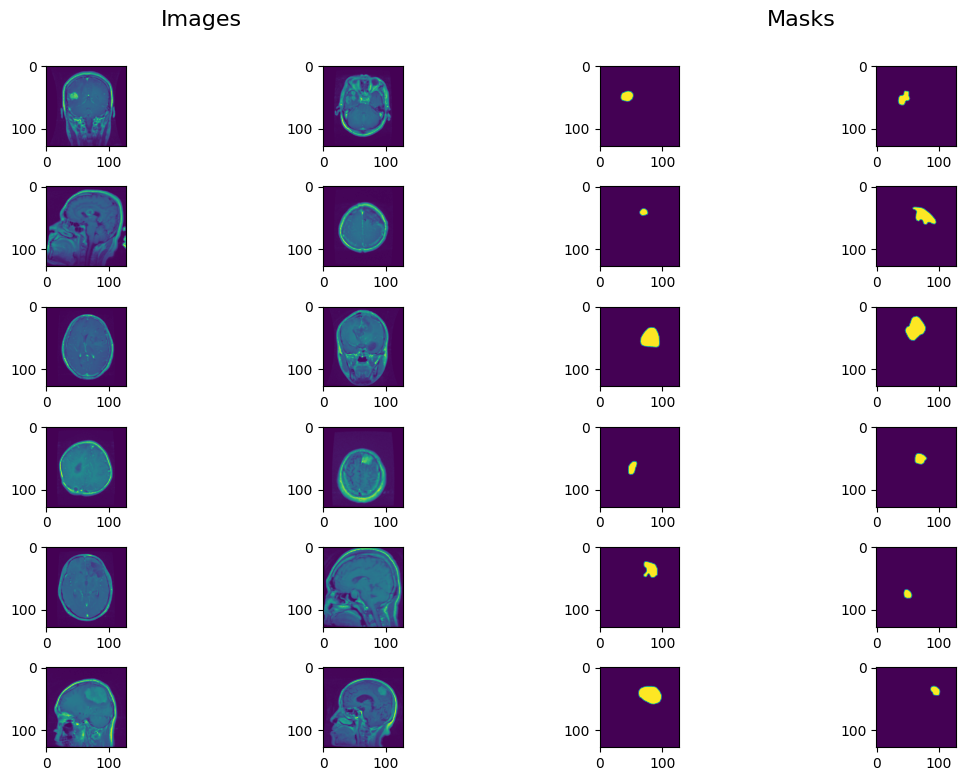

In [ ]:
def showSamples():
    img_batch = []
    mask_batch = []
    count = 2
    for img, mask in train_loader:
        img_batch.append(img)
        mask_batch.append(mask)
        if count <= 0:
            break
        count -= 1
    img_samples = []
    mask_samples = []
    for img_list, mask_list in zip(img_batch, mask_batch):
        for img , mask in zip(img_list, mask_list):
            img_samples.append((img.permute(1, 2, 0).detach().numpy()))
            mask_samples.append((mask.permute(1, 2, 0).detach().numpy()))
    figs, axs = plt.subplots(6, 4, figsize=(12, 8))

    for i in range(6):
        for j in range(2):
            idx = i*2 + j
            if idx < len(img_samples):
                axs[i, j].imshow(img_samples[idx])

    for i in range(6):
        for j in range(2, 4):
            idx = i*2 + (j - 2)
            if idx < len(mask_samples):
                axs[i, j].imshow(mask_samples[idx])


    figs.tight_layout()
    figs.subplots_adjust(top=0.9)
    figs.text(0.25, 0.95, 'Images', fontsize=16, ha='center')
    figs.text(0.75, 0.95, 'Masks', fontsize=16, ha='center')

    plt.show()

showSamples()

Training ( Skip if the purpose is only testing )

In [ ]:

#=================== Dice loss function ====================#
def loss_func(y_pred, y_true):
        smooth = 1.0
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + smooth) / (
            y_pred.sum() + y_true.sum() + smooth
        )
        return 1. - dsc
#==============================================================#


#================== Parameters =======================================#
lossFun = loss_func
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 300
#===================================================================#

# Training cause data to corrupt for some reason. Creating a new dataloader
# evey epoch solved the problem
def train(model, train_loader, optimizer, lossFun, epochs, device):
    losses = []
    for epoch in range(epochs):
        tempLoss = []
        model.train()
        images, masks = loadImagesMasks(img_path, mask_path, format)
        dataset = MriDataset(images, masks, transform)
        for img, mask in train_loader:
            img = img.to(device)
            mask = mask.to(device)

            yHat = model(img)
            loss = lossFun(yHat, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tempLoss.append(loss.item())
        avg_loss = np.mean(tempLoss)
        losses.append(avg_loss)
        sys.stdout.write(f'\rEpoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        train_loader= DataLoader(dataset, batch_size=16, shuffle=True, drop_last = True, num_workers=2)
    return losses

In [ ]:
train(model, train_loader, optimizer, epochs, device)

Testing

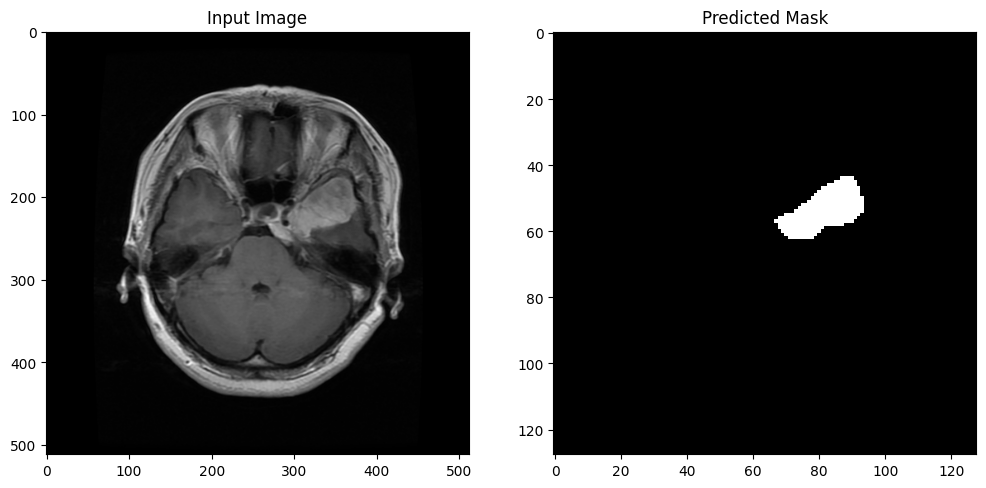

(128, 128, 1)
(128, 128, 1)


In [6]:
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

img_path = '/content/Mri/dataset/images/1.png'

input_image = Image.open(img_path)

preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


input = preprocess(input_image).to(device).unsqueeze(0)
output = model(input)


figs, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].imshow(input_image, cmap = 'gray')
axs[0].set_title('Input Image')

mask = torch.round(output.squeeze(0)).permute(1,2,0).detach().cpu().numpy()
axs[1].imshow(mask, cmap = 'gray')
axs[1].set_title('Predicted Mask')


plt.show()

print(mask.shape)
print(input.squeeze(0).permute(1,2,0).detach().cpu().numpy().shape)

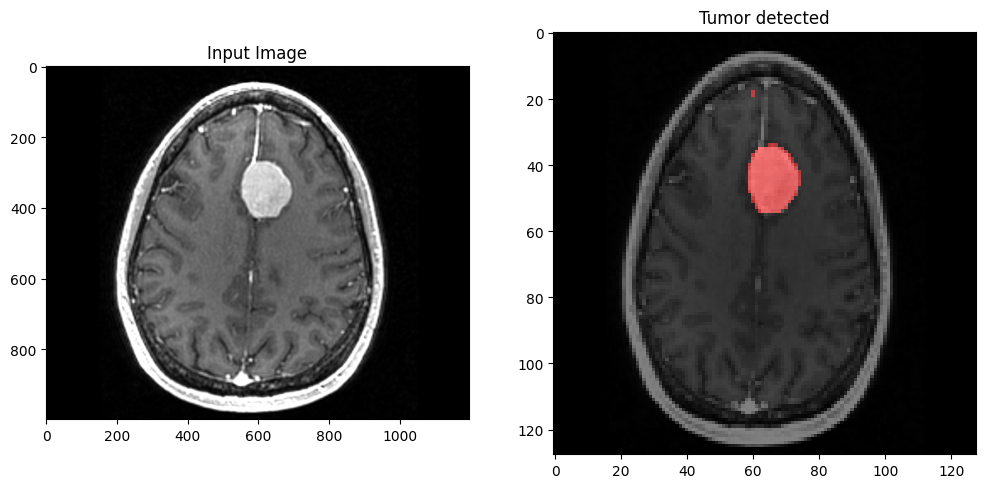

In [13]:
img_path = '/content/Mri/dataset/images/158.png'
input_image = Image.open('b2.jpg')

preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

input_tensor = preprocess(input_image).unsqueeze(0).to(device)
output = model(input_tensor)

mask = torch.round(output.squeeze(0)).permute(1, 2, 0).detach().cpu().numpy()
binary_mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)

input_image_np = np.array(input_image.resize((128, 128)))
input_image_np = cv2.cvtColor(input_image_np, cv2.COLOR_GRAY2RGB)  # convert grayscale to RGB

colored_mask = np.zeros_like(input_image_np)
colored_mask[binary_mask.squeeze() == 1] = [255, 0, 0]  # Red color

alpha = 0.5
highlighted_image = cv2.addWeighted(input_image_np, 1 - alpha, colored_mask, alpha, 0)

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(input_image, cmap='gray')
axs[0].set_title('Input Image')

axs[1].imshow(highlighted_image)
title = 'Tumor detected' if np.any(binary_mask) else 'No Tumor Detected'
axs[1].set_title(title)

plt.show()
